# Level 1

## Topic & Dataset Choosing

I choose the *Pet's Facial Expression Classification* problem,
dataset: [Pet's Facial Expression Image Dataset](https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset)

Start-up questions:

- **Q:** What is your plan for cleaning this dataset? <br>
  **A:** 1. Rename all images in a sequential order so it's easier for the dataloader to load data.

# Data Cleaning & Dataset Preparation

### Download, Unzip, & Reorganize Dataset

**Steps:**
1. Download the dataset from [Pet's Facial Expression Image Dataset](https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset).
2. Create a directory under current working directory to hold the dataset.

    ```bash
    $ mkdir dataset
    $ mv archive.zip dataset    # the zip you downloaded from Kaggle
    ```

3. Unzip and keep contents inside `Master Folder` only since it is well prepared.

    ```bash
    $ cd dataset
    $ unzip archive.zip
    $ rm -r Angry/ happy/ Other/ Sad/
    $ mv Master\ Folder/* .
    $ rmdir Master\ Folder
    ```

4. The `dataset` directory should look like this:

    ```bash
    $ # Go back to the original working directory
    $ tree -L 2 dataset
    dataset
    ├── archive.zip
    ├── test
    │   ├── Angry
    │   ├── Other
    │   ├── Sad
    │   └── happy
    ├── train
    │   ├── Angry
    │   ├── Other
    │   ├── Sad
    │   └── happy
    └── valid
        ├── Angry
        ├── Other
        ├── Sad
        └── happy

    15 directories, 1 file
    ```

---

### Renaming

Currently, directory names for each classification are inconsistent. We are going to rename them using all lowercase letters.
And, rename the `Other` classification to `undefined` (means undefined expressions) so the dataloader will treat it as the last classification.

Run the following code to rename directories in the dataset.

In [10]:
import os
from typing import List

def rename_classifications(directory: str) -> None:
    dirs: List[str];
    dirs = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    print(f'Renaming directories in "{directory}":')
    for d in dirs:
        new_name: str = d.lower() if d.lower() != 'other' else 'undefined'
        print(f'\t{d}\t->\t{new_name}')
        os.rename(os.path.join(directory, d), os.path.join(directory, new_name))

rename_classifications('dataset/train/')
rename_classifications('dataset/valid/')
rename_classifications('dataset/test/')

print('done')

Renaming directories in "dataset/train/":
	happy	->	happy
	Other	->	undefined
	Sad	->	sad
	Angry	->	angry
Renaming directories in "dataset/valid/":
	happy	->	happy
	Other	->	undefined
	Sad	->	sad
	Angry	->	angry
Renaming directories in "dataset/test/":
	happy	->	happy
	Other	->	undefined
	Sad	->	sad
	Angry	->	angry
done


---

Names of each image is not important, since
1. The dataloader will still work,
2. and sequence of images is not important


After this, the dataset should be ready to go.

---

### Load Data & Basic Preprocessing

We will load the dataset using `ImageFolder` class provided by PyTorch.

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose

# Basic & linear transforms, structure & relation of data will not change
transform: Compose = Compose([
    transforms.Resize((224, 224)),  # just to make sure
    transforms.ToTensor(),
])

# Load datasets (training, validation, test)
# Unprocessed
train_dataset_raw: ImageFolder = ImageFolder(root='dataset/train', transform=transform)
valid_dataset_raw: ImageFolder = ImageFolder(root='dataset/valid', transform=transform)
test_dataset_raw : ImageFolder = ImageFolder(root='dataset/test',  transform=transform)

In [7]:
# We are going to compute the mean $\mu$ & standard deviation $\sigma$

from typing import Tuple
from torch.utils.data import Dataset, DataLoader
import torch

def compute_mean_std(dataset: Dataset) -> Tuple[torch.Tensor, torch.Tensor]:
    dataloader: DataLoader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean: torch.Tensor = torch.zeros((3,))
    std: torch.Tensor = torch.zeros((3,))
    n: int = 0

    for images, _ in dataloader:
        images: torch.Tensor
        batch_sample_size: int = images.shape[0]
        images = images.reshape(batch_sample_size, 3, -1)
        # (bs, 3, -1) --(mean/std)--> (bs, 3) --(sum)--> (3,)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n += batch_sample_size
    
    mean /= n
    std /= n
    return mean, std

mean: torch.Tensor; std: torch.Tensor;
# Training set
mean, std = compute_mean_std(train_dataset_raw)
print(f'Training set: mean={tuple(f"{x:.3f}" for x in mean)}, std={tuple(f"{x:.3f}" for x in std)}')

# Use mean=(0.500, 0.456, 0.407) & std=(0.218, 0.213, 0.213) for later normalization
# We are using statistics only from the training set to prevent information leakage.

Training set: mean=('0.500', '0.456', '0.407'), std=('0.218', '0.213', '0.213')


### Reload & Normalize Dataset

In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose

# Basic & linear transforms, structure & relation of data will not change
transform: Compose = Compose([
    transforms.Resize((224, 224)),  # just to make sure
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.500, 0.456, 0.407), std=(0.218, 0.213, 0.213))
])

# Load datasets (training, validation, test)
# Unprocessed
train_dataset_raw: ImageFolder = ImageFolder(root='dataset/train', transform=transform)
valid_dataset_raw: ImageFolder = ImageFolder(root='dataset/valid', transform=transform)
test_dataset_raw : ImageFolder = ImageFolder(root='dataset/test',  transform=transform)

### Data Augmentation

Augmentations
- Flip
- Diversify colors
    > *Colors should not affect how we determine expressions, and colors could even cause interference.*
    > - A simple way to get through this is to turn images to gray-scale images, but we could **lose** information.
    > - If we jitter the colors, we could have data points that only differs in color while having the same classification.
    > The output (classification) is then **less** related to colors (given by the augmented dataset).
    >
    > Effect & Difference
    > - Mathematically (but not rigorously), suppose we already have a good embedding function that maps the dataset to
    > a low-dimentional feature space.
    >
    >   - $f: X \rightarrow F$, where $X=dataset \subseteq \mathbb{R}^n, F \subseteq \mathbb{R}^m$
    >   - $n>m$
    >   - $X$ and $F$ are discrete
    >
    > - Compare the feature space for gray-scaled input $F_{gray}$ with the feature space for colorly augmented input
    > $F_{aug}$.
    > - We are not only having more dimensions in $F_{aug}$, but we are also having more data in $F_{aug}$ (data points
    > are more dense) ($|F_{aug}| > |F_{gray}|$)
    > - Under the premise that we have a good embedding function, it is easier for our final classifier to fit smoother,
    > stabler, and more generalizable.
 - Rotation


In [2]:
# Preprocessing with data augmentation

transform: Compose = Compose([
    transforms.Resize((224, 224)),  # just to make sure
    transforms.RandomHorizontalFlip(),  # flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # diversify color
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.500, 0.456, 0.407), std=(0.218, 0.213, 0.213))
])

# Load datasets (training)
# Processed
train_dataset: ImageFolder = ImageFolder(root='dataset/train', transform=transform)

#### Detour: Visualize Raw & Augmented Dataset

The visualized result may not make any sense, but you may still see that the augmented
dataset looks more spread out after visualization.

(**NOTE:** This interpretation is not rigorous. UMAP only ensure the structure unchanged
locally. Thus, the visualize result cannot logically imply that the augmented dataset
is wider or denser. The visualization can only be the result of augmented dataset
being more diversified.)

In [23]:
# UMAP Dimension Reduction

import umap
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

def umap_embedding(dataset: Dataset,
                   pre_embed = lambda x: x,
                   iter_fetch_data: int = 1,
                   out_dimension: int = 2,
                   n_neighbors: int = 15,
                   metric: str = 'euclidean',
                   min_dist: float = 0.1,
                   seed: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    # Create a UMAP model
    umap_model: umap.UMAP;
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=out_dimension,
        metric=metric,  # *'cosine' is a common practice for high-dimensional data (an image has 3*224*224 dimensions)
        min_dist=min_dist,
        random_state=1024
    )

    # Random lucky seed, make sure results are reproducible
    g = torch.Generator().manual_seed(seed)
    vis_dataloader: DataLoader = DataLoader(dataset, batch_size=len(dataset), shuffle=False, generator=g)
    # Get all images
    images_flat: torch.Tensor = torch.Tensor()
    labels: torch.Tensor = torch.Tensor()
    for i in range(iter_fetch_data):
        _img: torch.Tensor; _lab: torch.Tenor;
        _img, _lab = next(iter(vis_dataloader))
        # Concatenate bs dimension
        images_flat = torch.cat((images_flat, _img), dim=0)
        labels = torch.cat((labels, _lab))

    # Flatten images: (bs*iter, 3, 224, 224) -> (bs*iter, 3*224*224)
    # *note: bs = batch size, iter = `iter_fetch_data`
    images_flat = images_flat.view(images_flat.shape[0], -1)

    # 
    images_umap: np.ndarray = umap_model.fit_transform(images_flat)
    return images_umap, np.asarray(labels)


In [10]:
# Visualize 2D Data - Scatter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def visualize_2d_features(features: np.ndarray) -> None:
    # Four colors (classes) only from `cmap='Set1'`
    cmap = ListedColormap(plt.cm.Set1.colors[:4])
    norm = BoundaryNorm(np.arange(0, 5, 1), cmap.N)    # Set boundary to integers only

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=cmap, norm=norm, s=10)
    plt.colorbar(scatter, label='Classifications')
    plt.title('UMAP Visualization')
    plt.show()

/home/josslei/.miniconda3/envs/targf/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


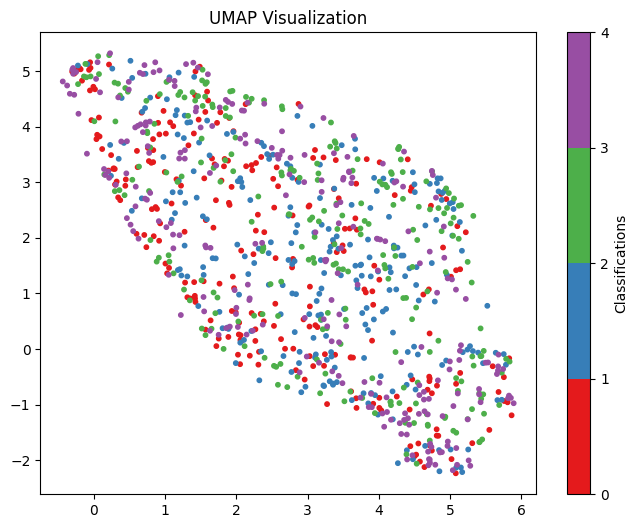

In [21]:
# Reduce Dimension & Visualize Unprocessed Dataset

import numpy as np

# Note: Calculation took about 40 seconds on my machine
images_umap: np.ndarray; labels: np.ndarray
images_umap, labels = umap_embedding(train_dataset_raw)
visualize_2d_features(images_umap)

/home/josslei/.miniconda3/envs/targf/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


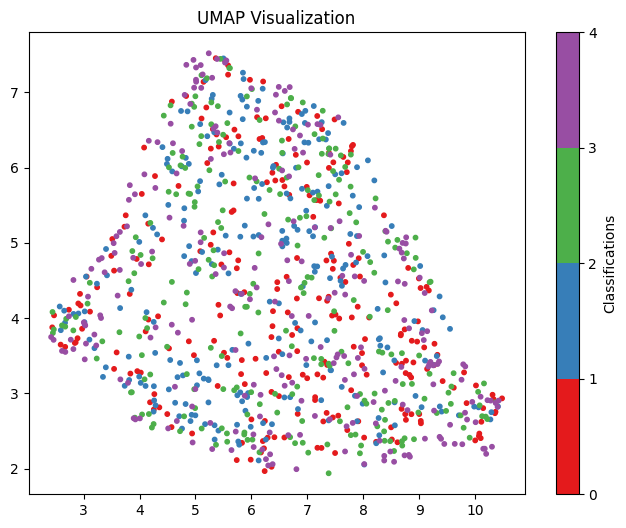

In [22]:
# Reduce Dimension & Visualize Augmented Dataset

import numpy as np

# Note: Calculation took about 55 seconds on my machine
images_umap: np.ndarray; labels: np.ndarray
images_umap, labels = umap_embedding(train_dataset)
visualize_2d_features(images_umap)

# Level 2

## Algorithm & Model Selection

We are going to use CNN (Convolutional Neural NetWork) + MLP (MultiLayer Perceptron) first.

Start-up questions:
- **Q:** What is your plan for creating this model? <br>
  **A:** Create a CNN + MLP model an train it.
- **Q:** Describe the algorithm that you chose. <br>
  **A:** First, CNN (Convolutional Neural Network) serves as an effective embedding function for dimension reduction and feature extraction in image processing. It is based on the assumption that each pixel in an image is highly dependent on the surrounding pixels, allowing it to capture local spatial features. While convolution operations are useful in traditional image processing, CNN trained by backward propagation is considered a valid & effective feature extractor for images both theoretically (keeps structures of neighbor pixels) and empirically. <br>
  Second, classification here is done by MLP (MultiLayer Perceptron). Simply saying, it is a composite of multiple *activated* linear transformations. An *activated* linear transformation is the composite of a *non-linear* function $\sigma$ and a linear transformation $T$: $\sigma \circ T$. The *non-linear* $\sigma$ is called the activation function. What we want from the MLP is that it should be able to fit the embedded dataset (the feature space). The structure of the feature space is unknown, but it is likely *not* linear. All compositions of linear functions are still linear (this is easy to prove), so we need some non-linear functions (activation layers) in between to let MLP has the potential to fit non-linear structures.
- **Q:** Detailed explanations on why you chose your algorithm and why you think it is best suited for your problem. <br>
  **A:** Reasons for why choosing CNN were explained by the previous answer. I believe there's no other tools that can handle images more effectively and simply than CNN. I'm using MLP for the classifier is because it is easier to train with, which they can be trained as a whole using backpropagation. The standard methodology works fine here, and let the code run first is important. But more importantly, MLP usually works more effectively in classification of complex problems (especially with CNN).
- **Q:** Mention any resources you used to help you in this portion of the challenge (we love links!). <br>
  **A:** These are knowledge that I remember from my previous learning & courses. But I use ChatGPT to assist me with coding.
- **Q:** Any extra information you'd like to include. <br>
  **A:** I reused some of my code in my previous projects (for the training loop), so there could be redundant code/checking statements if I don't have time to remove them.

In [3]:
# Create Model

from typing import Tuple

import torch
import torch.nn as nn

#cnn_config: dict = {
#    'batch_norm': True,
#    'cnn_structure': [8, 8, 'M', 16, 16, 'M', 32, 32, 'M']
#}

cnn_config: dict = {
    'batch_norm': True,
    'cnn_structure': [32, 'M', 64, 'M']
}


class SimpleCNN(nn.Module):
    """ A simple CNN backbone
    Suggested input size: (224, 224)
    """
    def __init__(self, config: dict, embed_dim: int = 128, num_class: int = 4):
        super().__init__()
        # Expand config
        batch_norm: bool = config['batch_norm']
        cnn_structure: list = config['cnn_structure']

        # Define model
        _conv2d_list: List[nn.Module] = []
        in_channels: int = 3
        for v in cnn_structure:
            if v == 'M':
                _conv2d_list += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(v) is int:
                _conv2d: nn.Module = nn.Conv2d(in_channels=in_channels, out_channels=v, kernel_size=3, padding=1)
                if batch_norm:
                    _conv2d_list += [_conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    _conv2d_list += [_conv2d, nn.ReLU(inplace=True)]
                in_channels = v
            else:
                raise Exception('CNN structure definition syntax error.')
        out_channels = in_channels
        self.embedding: nn.Module = nn.Sequential(*_conv2d_list)
        # Force mat size to become (bs, *, 7, 7)
        self.avgpool: nn.Module = nn.AdaptiveAvgPool2d((7, 7))
        self.mlp = nn.Sequential(
            nn.Linear(7 * 7 * out_channels, embed_dim),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(embed_dim, num_class)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.embedding(x)
        x = self.avgpool(x)
        feature: torch.Tensor = torch.flatten(x, 1)
        x = self.mlp(feature)
        return x, feature

In [7]:
# Main Training Iteration

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
from typing import List

# Random lucky seeds
g = torch.Generator().manual_seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
# Start from some reasonable random numbers
# After few experiments
num_epochs: int = 100
batch_size: int = 30
learning_rate: float = 0.002
#adam_betas: tuple = (0.5, 0.999)


# --- Train ---
# Dataloader
dataloader: DataLoader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=g,
        num_workers=4
    )
val_loader: DataLoader = DataLoader(
        valid_dataset_raw,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )

# Model
#cnn = torchvision.models.vgg16_bn(pretrained=True, num_class=4)
## Can't train vgg16 on my machine.
# Use a small cnn instead, and see how it would work.
cnn = SimpleCNN(cnn_config, num_class=4)
## Four classes are: angry, happy, sad, & undefined (other)
cnn = cnn.to(device)

# Optimizer - Adam
optimizer = optim.Adam(params=cnn.parameters(), lr=learning_rate)
# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=50)

# Training loop
loss_list_train: List[float] = []
loss_list_val: List[float] = []
acc_list: List[float] = []
writer = SummaryWriter('runs/experiment')   # TensorBoard
for epoch in trange(num_epochs):
    # Train
    # Iterate batches
    avg_loss: float = 0.0
    for _, data in enumerate(dataloader):
        images: torch.Tensor; labels: torch.Tensor
        images = data[0].to(device)
        labels = data[1].to(device)
        # Forward & Calc Loss
        cnn.train()
        output: torch.Tensor; cnn_feature: torch.Tensor; loss: torch.Tensor
        output, cnn_feature = cnn(images)
        loss = F.cross_entropy(output, labels)
        ## Note: `labels` is automatically casted into one-hot form
        ## Note: soft-max is automatically invoked in `F.cross_entropy`
        ## Note: REASONS FOR CHOOSING:
        ##  1. Handles probability distribution (the classifier (MLP layers) outputs a distribution)
        ##  2. Derived from (1), it fits classification problem with multiple classes
        ##  3. Cardinality of each class is balanced, doesn't need to be weighed

        # Back & update
        optimizer.zero_grad()   # Clear gradient from previous iter
        loss.backward()
        optimizer.step()
        # Record loss
        avg_loss += loss.item()
        pass

    # Validation
    cnn.eval()
    val_loss: float = 0.0
    num_correct: int = 0
    with torch.no_grad():
        for _, data in enumerate(val_loader):
            images: torch.Tensor; labels: torch.Tensor
            images = data[0].to(device)
            labels = data[1].to(device)
            # Forward & Calc Loss
            output: torch.Tensor;
            output, _ = cnn(images)
            loss: torch.Tensor = F.cross_entropy(output, labels)
            val_loss += loss.item()
            # Calc accuracy
            _, predicted = torch.max(output, 1)
            num_correct += (predicted == labels).sum().item()
            pass
        pass
    # Schedule learning rate
    scheduler.step(val_loss / len(valid_dataset_raw))
    # Record losses & accuracy
    loss_list_train += [avg_loss / len(dataloader)]
    writer.add_scalar('Training Loss', loss_list_train[-1], epoch)
    loss_list_val += [val_loss / len(valid_dataset_raw)]
    writer.add_scalar('Validation Loss', loss_list_val[-1], epoch)
    acc_list += [num_correct / len(valid_dataset_raw)]
    writer.add_scalar('Accuracy', acc_list[-1], epoch)
    pass

writer.close()
torch.save(cnn.state_dict(), 'model.pt')
#print(loss_list_train)

100%|██████████| 100/100 [08:27<00:00,  5.07s/it]


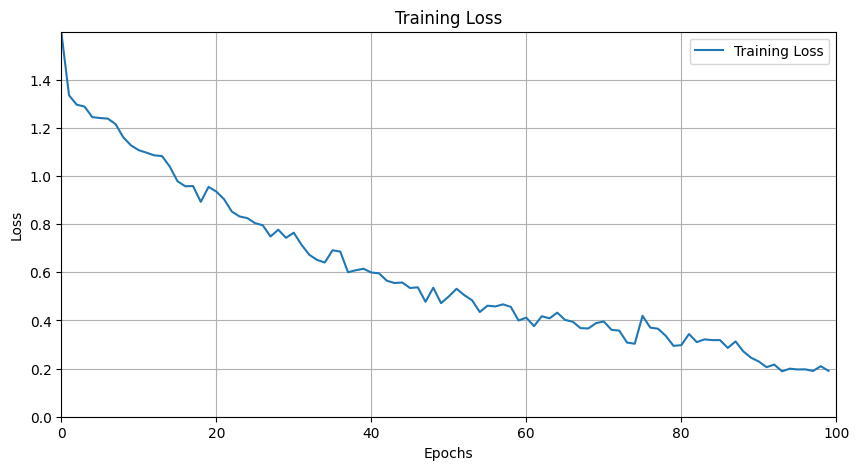

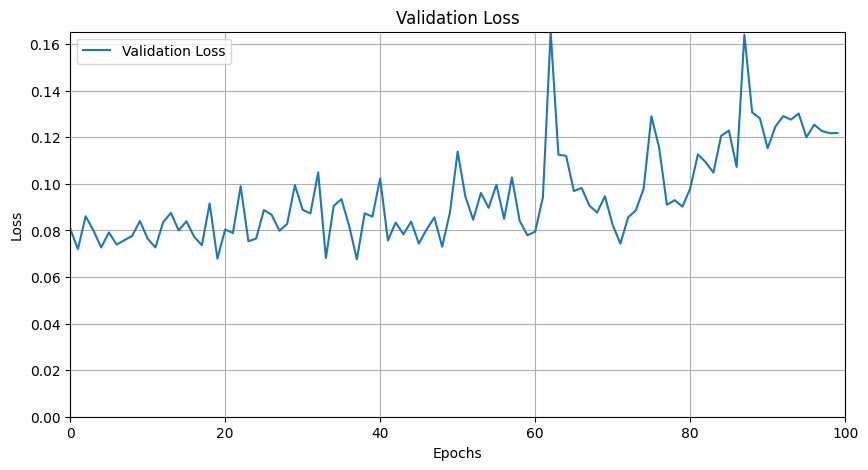

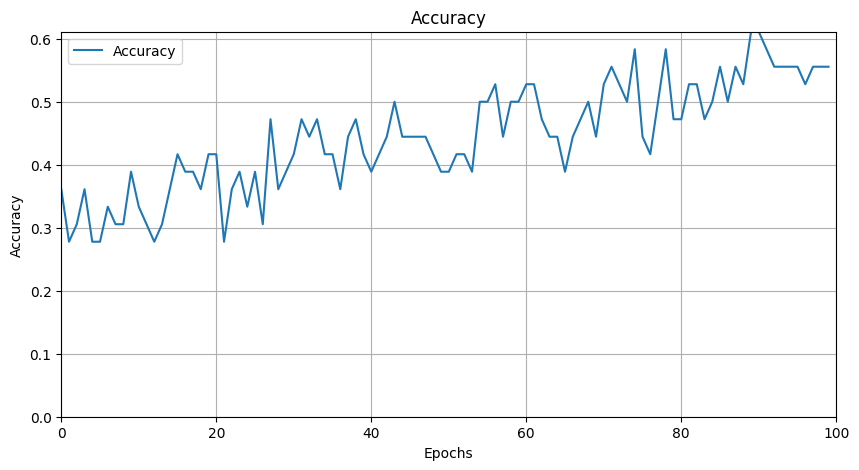

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(len(loss_list_train)))

def plot(title: str, num_epochs: int, y, y_label: str):
    plt.figure(figsize=(10, 5))
    x = list(range(num_epochs))
    plt.plot(x, y, label=title)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.xlim(0, num_epochs)
    plt.ylim(0, max(y))
    plt.legend()
    plt.grid()
    plt.show()

plot('Training Loss', len(loss_list_train), loss_list_train, 'Loss')
plot('Validation Loss', len(loss_list_val), loss_list_val, 'Loss')
plot('Accuracy', len(acc_list), acc_list, 'Accuracy')

# Level 3

After a few experiments I have a model that works OK on the validation set. Validation loss is still high (may not be representative compare to *accuracy* since I'm using cross-entropy loss), but due to time & machine limit (I would need to use a deeper CNN), I will use this as a temporary result to test. (Final validation accuracy of 0.5 is still better than guessing (0.25))

### Evaluation

Start-up questions:
- **Q:** What evaluation metrics did you choose to use? <br>
  **A:** For a balanced classification problem (multiple classes), *accuracy* is fair enough.
  $$Accuracy = \frac{\text{Number of Correctly Predicted}}{\text{Number of Images}}$$
- **Q:** What was the score you got for each of these metrics? <br>
  **A:** Evaluation code block is right below. <br>
         Unfortunately, the model I trained only reaches about 0.236, which is even slightly lower than pure guessing. I'll analyze it later.
- **Q:** Why were the specific evaluation metrics useful for the focus question you chose? <br>
  **A:** Each class in the dataset has equal amount of data (250 each), which is balanced. And for this problem, we don't need to lower false negative rate or false positive rate specifically (mistakes are not fatal). We only care about the correctness, or more general, the rate of correctness. Thus, this implies we should use *accuracy*.

#### Analysis

The biggest problem of my model is that the CNN embedding is too shallow, which means too little amount of feature extraction were done, too much max-pooling. Basically, it's not generalizing because of the network is too shallow. Simultaneously, I can't train it over too many epochs (to traverse more portion of the augmented dataset) because training loss is already steady, which it's likely that it cannot get better.

Currently, problem doesn't exist on MLP. In another word, if I make MLP wider or deeper, it could go overfit (with train loss still high).

Overall, CNN currently is currently not producing generalizable embeddings (too much reductions are done by max-pools, which may not be a semantic meaningful dimension reduction).

Too make it work better, few more experiments are needed.

In [11]:
# Evaluate Model

import torch

test_loader: DataLoader = DataLoader(
        test_dataset_raw,
        batch_size=36,
        shuffle=False,
        num_workers=4
    )

#cnn = SimpleCNN(cnn_config, num_class=4).to(device)
#cnn.load_state_dict(torch.load('model.pt'))

cnn.eval()
num_correct: int = 0
num_item: int = 0
with torch.no_grad():
    for _, data in enumerate(test_loader):
        images: torch.Tensor; labels: torch.Tensor
        images = data[0].to(device)
        labels = data[1].to(device)
        # Forward & Calc Loss
        output: torch.Tensor;
        output, _ = cnn(images)
        # Calc accuracy
        _, predicted = torch.max(output, 1)
        num_correct += (predicted == labels).sum().item()
        num_item += images.shape[0]
        pass
    pass

print(f'Accuracy = {num_correct / num_item}')

Accuracy = 0.23684210526315788
